## Analysis of MonoBeams of Z-Ring

New Boars of Jan are tested for monobeam recording

### Imports

In [1]:
import pandas as pd
import numpy as np
import obspy as obs
import matplotlib.pyplot as plt

from obspy.signal import PPSD
from andbro__querrySeismoData import __querrySeismoData

Matplotlib is building the font cache using fc-list. This may take a moment.


In [2]:
def __get_inventory_from_client(config):

    from obspy.clients.fdsn import Client

    cli = Client(base_url=config['client'], timeout=100)

    try:
        inv = cli.get_stations(network=config['seed'].split(".")[0],
                               station=config['seed'].split(".")[1],
                               location=config['seed'].split(".")[2],
                               channel='*',
                               starttime=tbeg,
                               endtime=tend,
                               level="response")
    except:
        print(f"ERROR: failed to load inventory for {config['seed'].split('.')[1]}!")

    return inv

### Configurations

In [3]:
config = {}

config['seeds'] = ["BW.DROMY..F1V", "BW.DROMY..F2V", "BW.DROMY..F3V",
                   "BW.DROMY..F4V", "BW.DROMY..F5V", "BW.DROMY..F6V",
                   "BW.DROMY..FJZ"]

## After running both mono beam boards. Random time selection
config['tbeg'] = obs.UTCDateTime("2023-03-23 01:00")
config['tend'] = obs.UTCDateTime("2023-03-23 01:30")

config['repo'] = "archive"

### Load Data

 -> loading BW.DROMY..F1V...
Coordinates could not be attached to Inventory!
 -> loading BW.DROMY..F2V...
Coordinates could not be attached to Inventory!
 -> loading BW.DROMY..F3V...
Coordinates could not be attached to Inventory!
 -> loading BW.DROMY..F4V...
Coordinates could not be attached to Inventory!
 -> loading BW.DROMY..F5V...
Coordinates could not be attached to Inventory!
 -> loading BW.DROMY..F6V...
Coordinates could not be attached to Inventory!
 -> loading BW.DROMY..FJZ...
Coordinates could not be attached to Inventory!


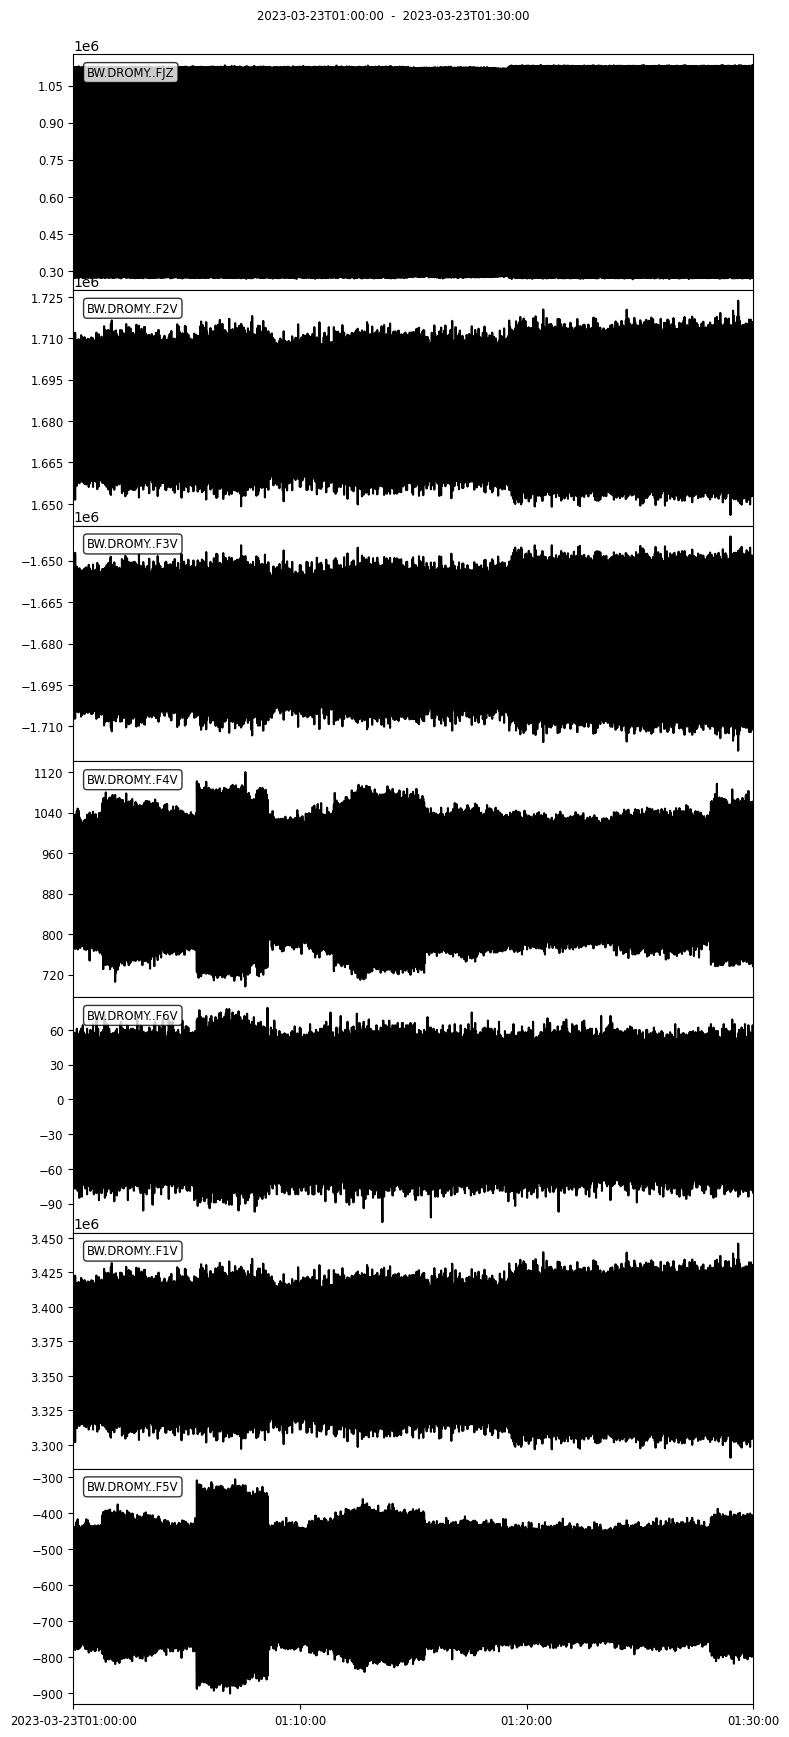

In [4]:
st0 = obs.Stream()
for seed in config['seeds']:

    print(f" -> loading {seed}...")
    st00, inv = __querrySeismoData(
                                seed_id=seed,
                                starttime=config.get("tbeg"),
                                endtime=config.get("tend"),
                                repository=config.get("repo"),
                                path=None,
                                restitute=False,
                                detail=True,
                                fill_value=None,
                                )
    
    st0 += st00

st0 = st0.sort()
    
st0.plot(equal_scale=False);

## Modify Data

In [22]:
st = st0.copy()
st = st.sort(['channel'])

### convert from counts to volts: 0.59604645ug  from obsidian

In [23]:
for tr in st:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

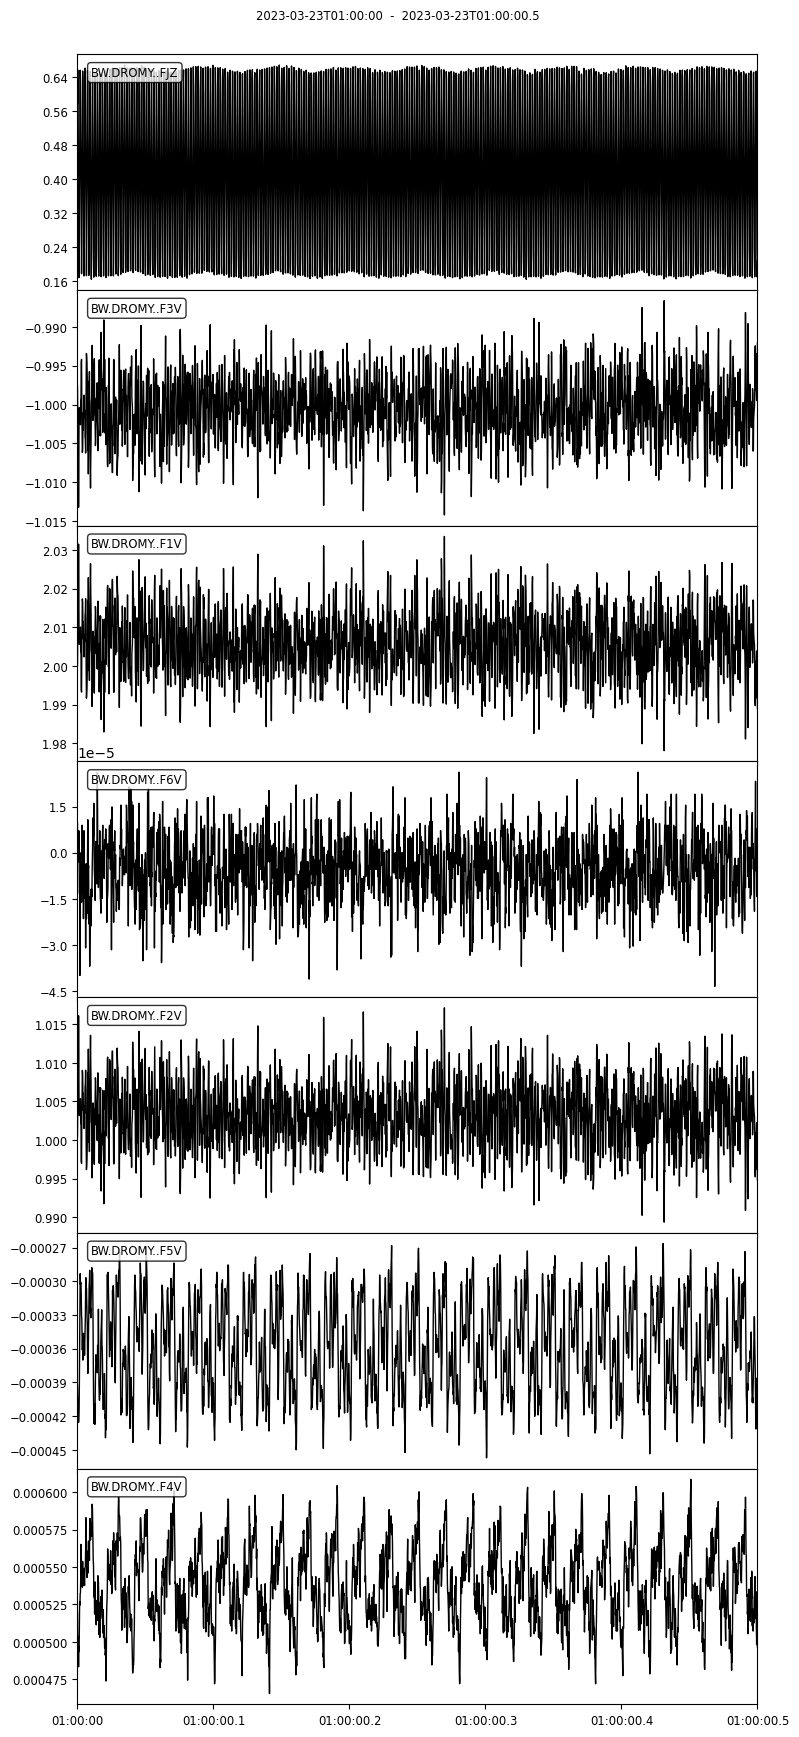

In [24]:
st.copy().sort().trim(config['tbeg'], config['tbeg']+0.5).plot(equal_scale=False);

### Plot FFT

In [25]:
def __compute_fft_stream(st):
    
    from andbro__fft import __fft
    from numpy import array
    
    ffts, freqs, chas = [], [], []

#     st.detrend('demean')

    for i, tr in enumerate(st):

        spectrum, frequencies, phase = __fft(tr.data, tr.stats.delta, window='hanning', normalize=False)
        
        ffts.append(spectrum)
        freqs.append(frequencies)
        chas.append(tr.stats.channel)
        
    return array(ffts), array(freqs), array(chas)

In [26]:
ffts, freqs, chas = __compute_fft_stream(st)

Hanning window applied 

Hanning window applied 

Hanning window applied 

Hanning window applied 

Hanning window applied 

Hanning window applied 

Hanning window applied 



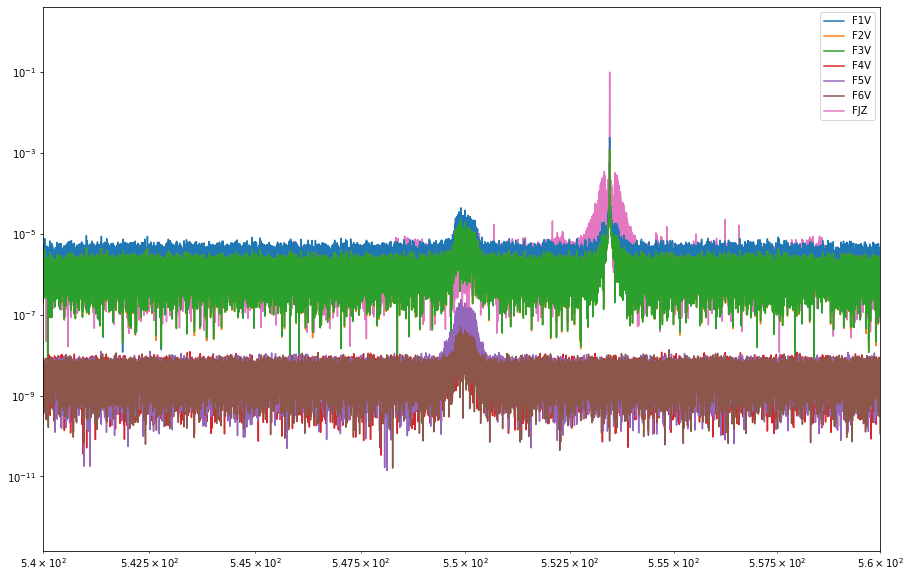

In [31]:
plt.figure(figsize=(15,10))

for f, fft, cha in zip(freqs, ffts, chas):

    if cha == "FJZ":
        plt.plot(f, fft, label=cha, zorder=-1)
    else:
        plt.plot(f, fft, label=cha)
    
    plt.xscale("log")
    plt.yscale("log")

    plt.xlim(540, 560)
    
    plt.legend(loc=1)
    
plt.show();

### Plot PSD

In [28]:
def __makeplot_stream_PSD(st, config):

    from scipy import fftpack
    from numpy import abs
    from scipy.signal import welch, hann
    import matplotlib.pyplot as plt


    nblock =  4096*100
    overlap = int(0.5*nblock)
    
    print(f" -> nseg = {nblock} | overlap = {overlap}")
    
    win = hann(nblock, True)

    
    fig, axes = plt.subplots(len(st),2,figsize=(15,10), sharex='col')

    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
    for i, tr in enumerate(st):

        ff, Pxx = welch(tr.data, fs=tr.stats.sampling_rate, 
                        window=win, noverlap=overlap, nfft=nblock,
                        scaling="density",
                        return_onesided=True)

        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times(),
                    tr.data,
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
        axes[i,1].loglog(
                    ff,
                    Pxx,
                    color='black',
                    lw=1.0,
                    )
        axes[i,1].set_ylim(min(Pxx[10:]), max(Pxx[10:]))
        
        axes[i,0].set_ylabel(r'U (volt)')    
        axes[i,1].set_ylabel(r'PSD (volt$^2$/Hz)')        
#         axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=.8)
        axes[i,0].legend(loc='upper left', framealpha=.8)
        
#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))    

        axes[i,1].set_xlim(530, 570)
    
    plt.show();
    return fig

 -> nseg = 409600 | overlap = 204800


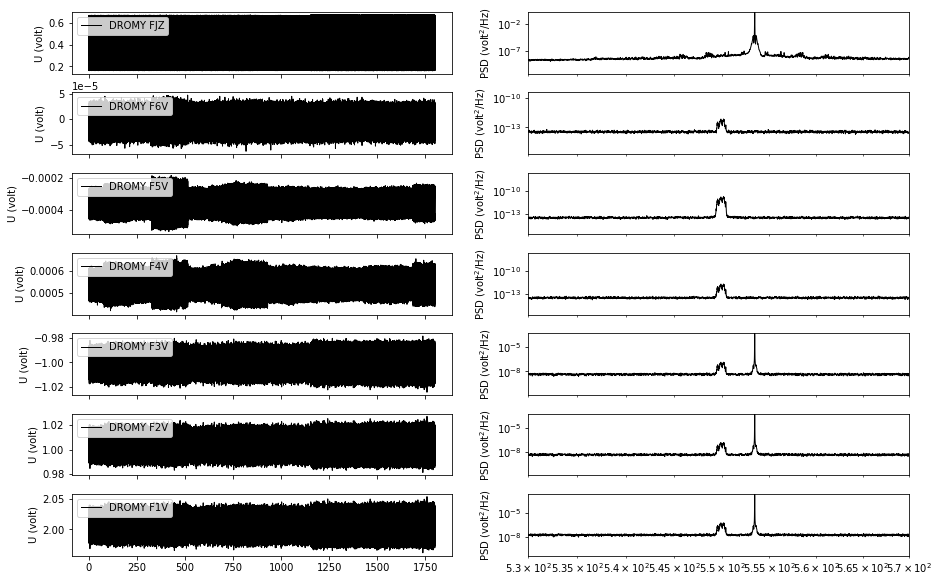

In [29]:
__makeplot_stream_PSD(st, config);

### Processing

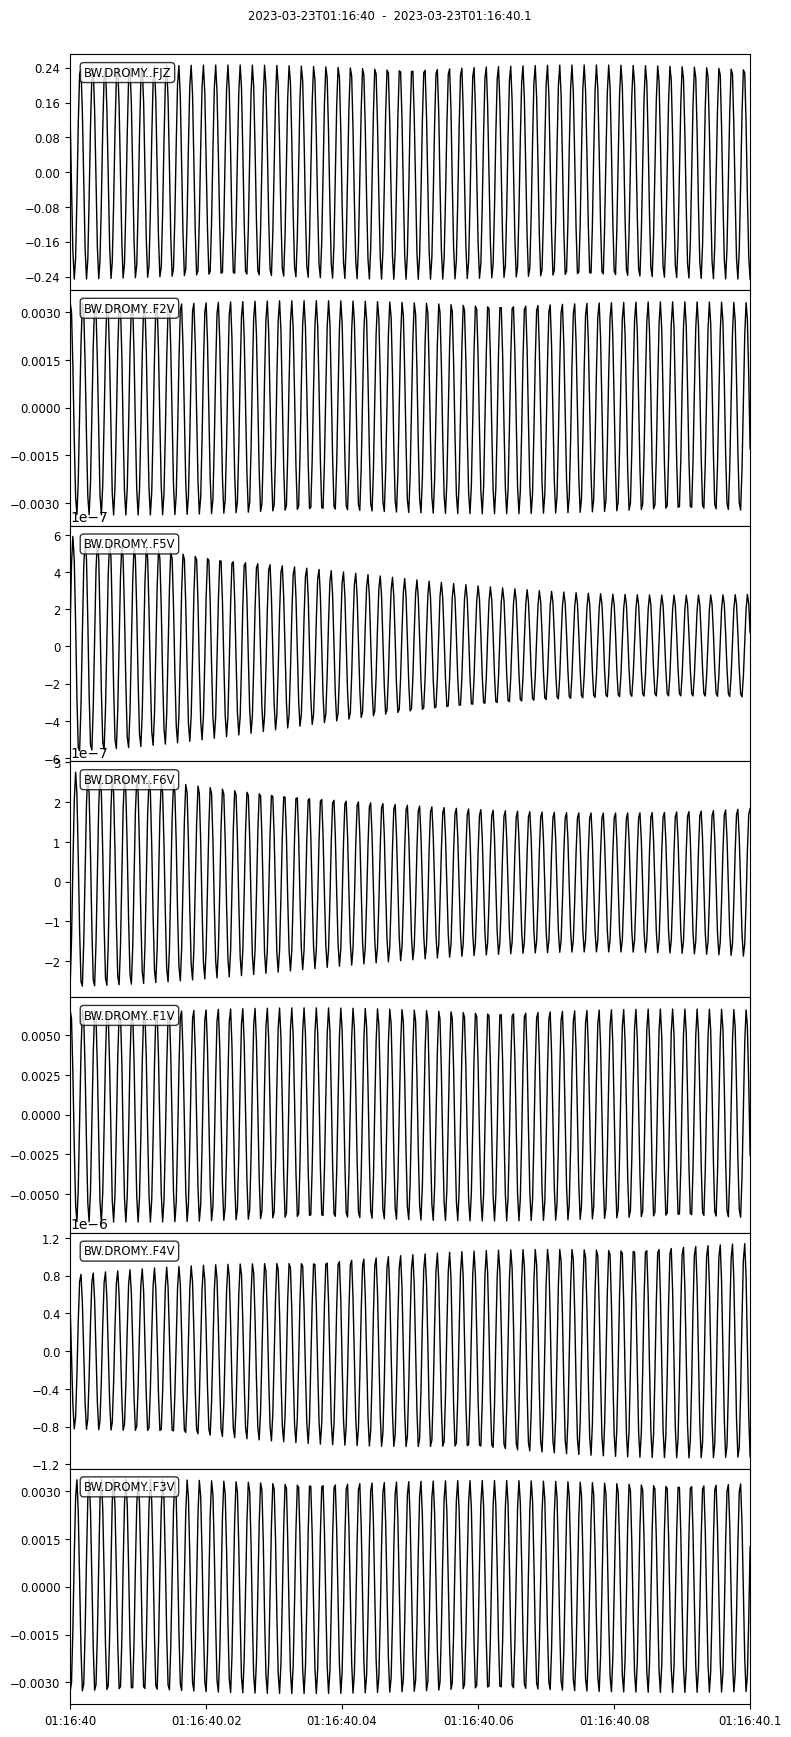

In [36]:
st_pro = st.copy()

st_pro.detrend('simple')

st_pro.taper(0.1)

fmin, fmax = 551, 555

st_pro.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

# st_pro.filter('lowpass', freq=fmax, corners=8, zerophase=True)
# st_pro.filter('highpass', freq=fmin, corners=4, zerophase=True)
# st_pro.filter('bandstop', freqmin=0.05, freqmax=0.08, corners=4)

st_pro.trim(config['tbeg']+1000, config['tbeg']+1000.1).plot(equal_scale=False);

In [14]:
ffts, freqs, chas = __compute_fft_stream(st_pro)

Hanning window applied 

Hanning window applied 

Hanning window applied 

Hanning window applied 

Hanning window applied 

Hanning window applied 

Hanning window applied 



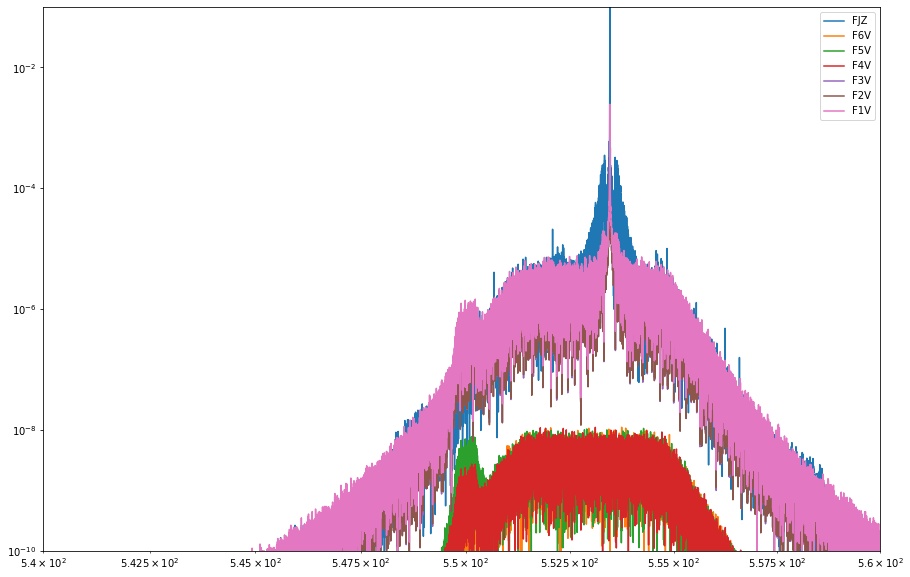

In [15]:
plt.figure(figsize=(15,10))

for f, fft, cha in zip(freqs, ffts, chas):
    plt.plot(f, fft, label=cha)
    
    plt.xscale("log")
    plt.yscale("log")

    plt.xlim(540, 560)
    
    plt.ylim(1e-10, 1e-1)
    
    plt.legend(loc=1)
    
plt.show();